# Polarization reconstruction debugging (almost there!!)

### Sep 28, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")

Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
# mpl.rcParams['mathtext.rm'] = 'Times New Roman'
# mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
# mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# mpl.rc('font', family='serif', size=12)
# mpl.rcParams['xtick.labelsize'] = 14
# mpl.rcParams['ytick.labelsize'] = 14
# mpl.rcParams['xtick.major.size'] = 5
# mpl.rcParams['ytick.major.size'] = 5

# mpl.rcParams['axes.titlesize'] = 18
# mpl.rcParams['axes.labelsize'] = 18
# # mpl.rc('font', size=16)
# mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Define function

In [104]:
def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
#     np.random.seed(9)
    phi = np.random.uniform(0,2*np.pi)
    costheta = np.random.uniform(0,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = costheta
    return np.array([x,y,z])

In [105]:
# phi = np.deg2rad(90)
# theta = np.deg2rad(90)
from scipy import signal
pol_ev = np.array([0.,0,1])
dirProp = np.array([0,1,0])
# pol_ev = np.array([0.73464503,0.66096714,0.15303304])
# dirProp = np.array([0.12301928,0.09204764,0.98812625])

# dirProp = random_three_vector()
phi = np.arctan2(dirProp[1],dirProp[0])
print("phi:%0.2f"%phi)
theta = np.arccos(dirProp[2])
print("theta:%0.2f"%np.degrees(theta))

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
# antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV

phi:1.57
theta:90.00


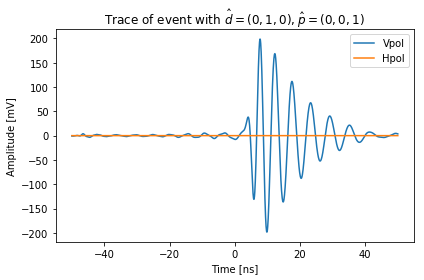

In [106]:
# plt.figure(figsize=(6,3))
sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
outputH = antH.front_end(sigH)
timeH = outputH.times*1E9 #in ns
voltageH = outputH.values*1E3 #in mV

plt.plot(timeV,voltageV, label="Vpol")
plt.plot(timeH,voltageH, label="Hpol")
plt.title("Trace of event with $\hat{d}=(0,1,0), \hat{p}=(0,0,1)$")
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/trace_example.pdf')

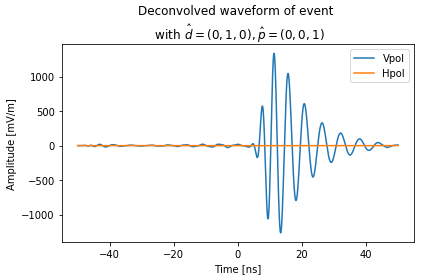

In [107]:
deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
plt.plot(deConv_V_t,deConv_V_v, label = "Vpol")
plt.plot(deConv_H_t,deConv_H_v, label = "Hpol")
plt.legend()
plt.title("Deconvolved waveform of event \n with $\hat{d}=(0,1,0), \hat{p}=(0,0,1)$")
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV/m]")
plt.tight_layout()
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/deconvolved_example.pdf')

### Calculate polarization angle from Stokes parameters

In [108]:
def PolAngleStokes(Hpol,Vpol):
    return np.degrees(0.5*np.arctan2(2*Hpol*Vpol,(Vpol**2-Hpol**2)))

# Generate random polarizations

dir_prop:[ 0.06237686 -0.00326669 -0.99804732]
pol_vec:[ 0.99306249 -0.09967036  0.06239154]
theta_prop:176.419
theta_reco:2.728
theta_true:86.423
Dot product is -0.000000


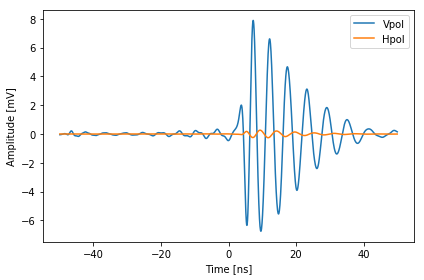

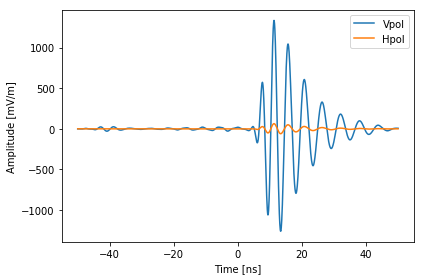

In [115]:
reco=[]
true=[]
phi_ = []
dot = []
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, -100), power_threshold=0)
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, -100), power_threshold=0)
# antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
# antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
for count in range(0,1000):
#     dirProp = np.array([1/np.sqrt(2),0,1/np.sqrt(2)])
    dirProp =  random_three_vector()
#     pol_ev = np.random.randn(3)  # take a random vector
#     pol_ev -= pol_ev.dot(dirProp) * dirProp       # make it orthogonal to k
#     pol_ev /= np.linalg.norm(pol_ev) 
    phi2 = np.arctan2(dirProp[1],dirProp[0]) % (2*np.pi)
    theta2 = np.arccos(dirProp[2])
    pol_ev=np.array([-np.sin(theta2)/np.cos(phi2),-np.cos(theta2)**2/(np.sin(theta2)*np.sin(phi2)),1/np.cos(theta2)])
    
    _, theta, phi = antV.antenna._convert_to_antenna_coordinates(antV.position - normalize(dirProp))
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos(theta)
    newdirProp = np.array([x,y,z])
    y_axis = np.cross(antV.antenna.z_axis, antV.antenna.x_axis)
    transformation = np.array([antV.antenna.x_axis, y_axis, antV.antenna.z_axis])
    ant_pol = np.dot(transformation, normalize(pol_ev))
#     pol_ev2 = np.random.randn(3)  # take a random vector
#     pol_ev2 -= pol_ev.dot(newdirProp) * newdirProp       # make it orthogonal to k
#     pol_ev2 /= np.linalg.norm(pol_ev2) 
#     phi = np.arctan2(dirProp[1],dirProp[0])
#     theta = np.arccos(dirProp[2])
#     pol_ev = random_three_vector()
    
    sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
    output = antV.front_end(sig)

    timeV = output.times*1E9 #in ns
    voltageV = output.values*1E3 #in mV

    sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

    sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
    outputH = antH.front_end(sigH)
    timeH = outputH.times*1E9 #in ns
    voltageH = outputH.values*1E3 #in mV

    deConv_V_t,deConv_V_v = deConvolve_antenna(timeV, voltageV, theta, phi, 0)
    deConv_H_t,deConv_H_v = deConvolve_antenna(timeH, voltageH, theta, phi, 1)
    reco_ = PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))
    true_ = np.degrees(np.arccos(ant_pol[2]))
#     if(np.dot(newdirProp,ant_pol)>0.1):
#         print(np.dot(newdirProp,ant_pol)>0.1)
# #         break
#     if(reco_-true_>100):
# # #         continue
# # #         true_=abs(90-true_)
    if(reco_-true_<-80):
        print("dir_prop:%s"%newdirProp)
        print("pol_vec:%s"%ant_pol)
        print("theta_prop:%0.3f"%np.degrees(theta))
        print("theta_reco:%0.3f"%reco_)
        print("theta_true:%0.3f"%true_)
#         print(np.degrees(np.arccos(pol_ev[2])))
        print("Dot product is %f"%np.dot(newdirProp,ant_pol))
#         plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
#         plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
        plt.figure()
        plt.plot(timeV,voltageV,label="Vpol")
        plt.plot(timeH,voltageH, label="Hpol")
        plt.xlabel("Time [ns]")
        plt.ylabel("Amplitude [mV]")
        plt.legend()
        plt.tight_layout()
#         plt.savefig(my_path_plots+'/Stokes/Sep30Call/trace_example_RightTail.pdf')
        plt.figure()
        plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
        plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
        plt.xlabel("Time [ns]")
        plt.ylabel("Amplitude [mV/m]")
        plt.legend()
        plt.tight_layout()
#         plt.savefig(my_path_plots+'/Stokes/Sep30Call/deconvolved_example_RightTail.pdf')
        break

    reco.append(reco_)
    true.append(true_)
    phi_.append(np.degrees(phi))
    dot.append(np.dot(newdirProp,ant_pol))
#     print((PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))-np.degrees(theta)))

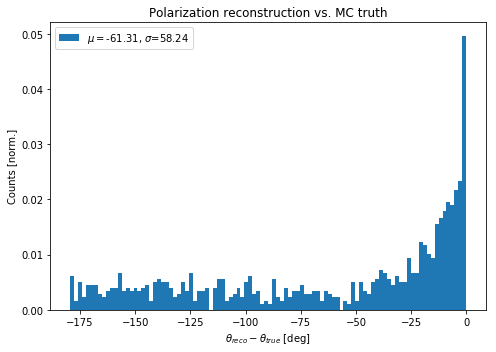

In [103]:
reco=np.array(reco)
true=np.array(true)
phi_=np.array(phi_)
plt.figure(figsize=(7,5))
plt.hist(reco-true, bins=100, density=True, alpha=1,label="$\mu=$%0.2f, $\sigma$=%0.2f"%((reco-true).mean(),(reco-true).std()));

plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/recoVsTrue_MC.pdf')

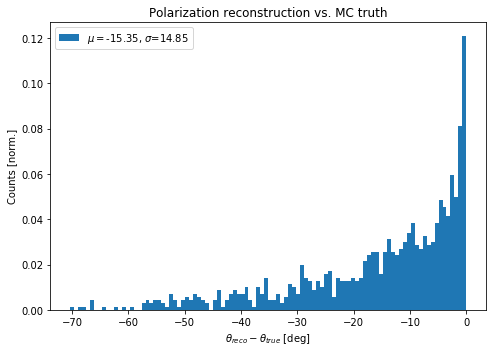

In [96]:
reco=np.array(reco)
true=np.array(true)
phi_=np.array(phi_)
plt.figure(figsize=(7,5))
plt.hist(reco-true, bins=100, density=True, alpha=1,label="$\mu=$%0.2f, $\sigma$=%0.2f"%((reco-true).mean(),(reco-true).std()));

plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/recoVsTrue_MC.pdf')

# Debug deconvolution

In [91]:
def deConvolve_antenna(time, voltage, theta, phi, pol_ant):
    import pyrex.custom.ara as ara
    import scipy.signal as signal
    polarization=np.array([-np.sin(phi),np.cos(phi),-1/np.sin(theta)])
    if(pol_ant == 0):
        ant = ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
        # ant.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))#Adding to convert from global coordinates to local antenna coords.
    elif(pol_ant == 1):
        ant = ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
        # ant.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))

    sampRate = len(time)/(max(time)-min(time))
    b,a = signal.bessel(4, [0.15,0.4], 'bandpass', analog=False, fs=sampRate)
    fft_v, fft_f, dT = util.doFFT(time,voltage)
    response_filter = np.array(ant.interpolate_filter(fft_f*1E6))
    dir_res = ant.antenna.directional_response(theta=theta, phi=phi, polarization=polarization)(fft_f*1E6)
    heff = ant.antenna.frequency_response(fft_f*1E6)
    response_antenna = dir_res*heff
    response = response_antenna
    deDis_wf = np.divide(fft_v,abs(response))
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(deDis_wf,response)
    deDis_wf = np.nan_to_num(deDis_wf)
    revert = util.doInvFFT(deDis_wf)
    deDis_wf = signal.lfilter(b, a, revert)
    return time, deDis_wf

In [92]:
deConv_V_t,deConv_V_v = deConvolve_antenna(timeV, voltageV, theta, phi, 0)
deConv_H_t,deConv_H_v = deConvolve_antenna(timeH, voltageH, theta, phi, 1)

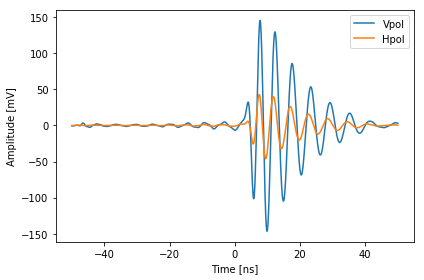

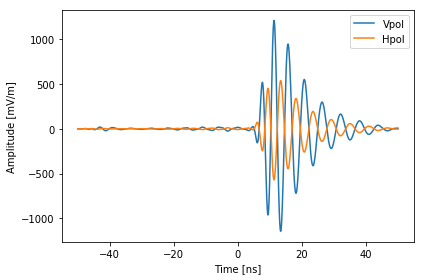

In [93]:
plt.figure()
plt.plot(timeV,voltageV,label="Vpol")
plt.plot(timeH,voltageH, label="Hpol")
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
#         plt.savefig(my_path_plots+'/Stokes/Sep30Call/trace_example_RightTail.pdf')
plt.figure()
plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV/m]")
plt.legend()
plt.tight_layout()